# JPE cleaning
This notebook walks through how the JPE articles were sorted into categories of articles and non-articles.

## Loading libraries

In [1]:
from tokenize import Ignore
import pandas as pd
from difflib import SequenceMatcher
import multiprocessing as mp
import time
from os import path
import os
from pathlib import Path
from PyPDF2 import PdfFileReader, PdfFileWriter
import re
import numpy as np
import matplotlib.pyplot as plt


pd.set_option('display.max_rows',100)
pd.set_option('display.max_colwidth', 120)   

## Loading Files
Please replace file paths with local file paths and comment out unapplicable content eg: datadump

In [2]:
base_path="/Users/sijiawu/Work/Thesis/Data"

In [3]:
masters = pd.read_excel(base_path+"/Masterlists/JPE_Masterlist.xlsx")
masters10 = pd.read_excel(base_path+ "/2010/JPE_master.xlsx")
pivots = pd.read_excel(base_path+"/Pivots/JPE_Pivots2020.xlsx")

## Create File names
Again, replace these with local file paths

In [4]:
saveas=base_path+"/Processed/JPE_processed.xlsx"

## Some random checks on the masters list
My assumption is that all data without author names must be miscellaneous documents like reports by the committee, forewords, front matters etc.. The goal of this notebook is to check for certain that all the documents without author names are actually miscellaneous documents and then classify them as miscellaneous (MISC). Hence, first we group everything the data by title to see the repetitive general content that can likely be removed.

In [5]:
pd.set_option('display.max_rows',masters.shape[0])
temp=masters['title'].str.lower().value_counts()
pd.DataFrame(temp[temp>1]).head(10)

,count
title,
front matter,431
back matter,322
books received,248
volume information,137
washington notes,110
journal of political economy: acknowledges the assistance of:,74
new publications,50
journal of political economy,43
back cover,29


Some repetitions are due to multiple comments. Now consider this list in absence of author names.

In [6]:
temp2=masters[masters['author'].isna()]['title'].str.lower().value_counts()
pd.DataFrame(temp2).head(10)

,count
title,
front matter,431
back matter,322
books received,248
volume information,137
washington notes,110
journal of political economy: acknowledges the assistance of:,74
new publications,50
journal of political economy,43
back cover,29


In [7]:
masters["content_type"]=None
temp2=masters[masters['content_type'].isna()==True]['title'].str.lower().value_counts()
#pd.DataFrame(temp2)
removal=list(temp2[temp2>=5].index)
masters.loc[masters.title.str.lower().isin(removal),'content_type']='MISC'

## Combine the scraped list with the citations files

I have found that masterlists contructed from citation files lack the reviewed source's name while it is present on the page of the article. Some files are just missing the title. So I'm combining the old masterlists with the new ones.

In [8]:
masters["URL"]="https:"+masters["URL"].str.split(':').str[-1]
masters.drop('type', inplace=True, axis=1)
masters10["stable_url"]="https:"+masters10["stable_url"].str.split(':').str[-1]
masters10.rename(columns = {'authors':'author','stable_url':'URL','title':'title_10'}, inplace = True)
masters['pages']=masters['pages'].str.strip()  
masters.loc[masters.title.str.lower() == "back matter", 'pages'] = pd.NA  
pivots['type']=pd.NA
masters['pages']=masters["pages"].str.split('pp. ').str[-1]
masters['pages']=masters['pages'].replace(r'--','-',regex=True).str.strip()

In [9]:
masters["author_split"]=masters['author'].str.split(' and ')
masters=masters.merge(masters10[['URL', 'title_10']], how='left', on='URL')

In [10]:
masters.loc[(pd.isna(masters["title"])==True)&(pd.isna(masters["reviewed-author"])==False), 'content_type']="Review"
masters.loc[((masters['title'].str.lower().str.contains('book reviews indexed by author of book')==True)),'content_type']='Review'

In [11]:
masters.loc[(pd.isna(masters["title"])==True)&(pd.isna(masters["reviewed-author"])==False),"title"]=masters[(pd.isna(masters["title"])==True)&(pd.isna(masters["reviewed-author"])==False)]["title_10"]
masters.loc[(pd.isna(masters["title_10"])==False)&(pd.isna(masters["title"])==True)&(pd.isna(masters["reviewed-author"])==True)&(pd.isna(masters["author"])==True),"title"]=masters[(pd.isna(masters["title_10"])==False)&(pd.isna(masters["title"])==True)&(pd.isna(masters["reviewed-author"])==True)&(pd.isna(masters["author"])==True)]["title_10"]

In [12]:
for i in masters[(pd.isna(masters["title_10"])==False)&(pd.isna(masters["title"])==True)&(pd.isna(masters["reviewed-author"])==True)].index:
    temp=masters.iloc[i]
    indic=0
    if len(temp['author_split'])>1:
        for j in temp['author_split']:
            if j in temp["title_10"]:
                indic=1
                masters.loc[i, "title"]=temp["title_10"]
                masters.loc[i, "reviewed-author"]=j
                masters.loc[i, "content_type"]="Review"
                if "Review by:" in temp["title_10"]:
                    print("weird")
    if indic==0:
        masters.loc[i, 'title']=temp['title_10']

In [13]:
masters10.head()

,URL,author,title_10,abstract,content_type,issue_url,pages
0,https://www.jstor.org/stable/26549909,NaN,JOURNAL OF POLITICAL ECONOMY,NaN,NaN,https://www.jstor.org/stable/10.2307/e26549908,NaN
1,https://www.jstor.org/stable/26549910,NaN,Journal of Political Economy,NaN,NaN,https://www.jstor.org/stable/10.2307/e26549908,NaN
2,https://www.jstor.org/stable/26549911,Johannes Hörner and Andrzej Skrzypacz,Selling Information,NaN,NaN,https://www.jstor.org/stable/10.2307/e26549908,1515-1562
3,https://www.jstor.org/stable/26549912,Gabriel Chodorow-Reich and Loukas Karabarbounis,The Cyclicality of the Opportunity Cost of Employment,NaN,NaN,https://www.jstor.org/stable/10.2307/e26549908,1563-1618
4,https://www.jstor.org/stable/26549913,David Gill and Victoria Prowse,"Cognitive Ability, Character Skills, and Learning to Play Equilibrium: A Level-k Analysis",NaN,NaN,https://www.jstor.org/stable/10.2307/e26549908,1619-1676


In [14]:
masters[masters.title.isna()]

,issue_url,ISSN,URL,journal,number,publisher,title,urldate,volume,year,author,pages,abstract,reviewed-author,content_type,author_split,title_10


## Classifying miscellaneous documents

In [15]:
masters.loc[masters.apply(lambda k: SequenceMatcher(None, k['title'].lower(), 'front matter').ratio(), axis=1)>0.75,"content_type"]='MISC'
masters.loc[masters.apply(lambda k: SequenceMatcher(None, k['title'].lower(), 'back matter').ratio(), axis=1)>0.75,"content_type"]='MISC'
masters.loc[masters.apply(lambda k: SequenceMatcher(None, k['title'].lower(), 'volume information').ratio(), axis=1)>0.75,"content_type"]='MISC'
masters.loc[masters.apply(lambda k: SequenceMatcher(None, k['title'].lower(), 'books recieved').ratio(), axis=1)>0.75,"content_type"]='MISC'
masters.loc[masters.apply(lambda k: SequenceMatcher(None, k['title'].lower(), 'washington notes').ratio(), axis=1)>0.75,"content_type"]='MISC'
masters.loc[masters['title'].str.lower().str.match(r'(in )?memor(y|i(a|u)(m|l))')==True, 'content_type']='MISC'
masters.loc[masters.apply(lambda k: SequenceMatcher(None, k['title'].lower(), 'books reccieved').ratio(), axis=1)>0.75,'content_type']='MISC'
masters.loc[masters['title'].str.lower().str.match(r'^journal of political economy(.*)')==True,'content_type']='MISC'
masters.loc[masters['title'].str.lower().str.match(r'^index to volume.*')==True,'content_type']='MISC'
masters.loc[masters['title'].str.lower().str.match(r'^new publications')==True,'content_type']='MISC'
masters.loc[masters['title'].str.lower().str.match(r'^(prefatory |\[)note(|s)(|\])$')==True,'content_type']='MISC'
masters.loc[masters['title'].str.lower().str.match(r'^(|\[)questions and answers(\]|)$')==True,'content_type']='MISC'
masters.loc[masters['title'].str.lower().str.match(r'^(|short )notice(|s)$')==True,'content_type']='MISC'
masters.loc[masters['title'].str.lower().str.match(r'^back cover(.*)')==True,'content_type']='MISC'
masters.loc[masters['title'].str.lower().str.match(r'^introduction(.*)')==True,'content_type']='MISC'
masters.loc[masters['title'].str.lower().str.match(r'^combined references(.*)')==True,'content_type']='MISC'
masters.loc[masters['title'].str.lower().str.match(r'^editor')==True, 'content_type']="MISC"
masters.loc[masters['title'].str.lower().str.match(r'^from the editor')==True, 'content_type']="MISC"
masters.loc[masters['title'].str.lower().str.contains(r'^jpe.*')==True, 'content_type']='MISC'
masters.loc[masters['title'].str.lower().str.contains(r'^preface$')==True, 'content_type']='MISC'
masters.loc[masters['title'].str.lower().str.contains(r'^the annual meetings$')==True, 'content_type']='MISC'
masters.loc[masters['title'].str.lower().str.contains(r'\[photograph\]')==True, 'content_type']="MISC"
masters.loc[masters['title'].str.lower().str.match(r'^(dissertations|john bates clark: a memorial|volume infomation|volume infromation)$')==True,'content_type']='MISC'

## Classifying other content types

In [16]:
# check for how many articles are still unclassified
sum(masters.content_type.isna())
#masters.shape[0]

6712

In [18]:
masters.loc[(masters['title'].str.lower().str.match(r'(.*) by (.*)')==True) & (masters.author.isna()==True),'content_type']='Review2' 
#possible reviews that don't have author names
masters.loc[~(masters['author'].isna()) & (masters['reviewed-author'].isna()==False),'content_type']='Review'


In [19]:
masters.loc[masters.content_type.isna() & masters.title.str.lower().str.match(r'.*: (|a )comment(|.*)$')==True,'content_type']='Comment'
masters[masters['content_type']=='Comment'].shape[0] #comments

166

In [20]:
masters.loc[masters.content_type.isna() & masters.title.str.lower().str.match(r'.*(:|\?) (|a )reply(| to.*)$')==True,'content_type']="Reply"
masters[masters['content_type']=='Reply'].shape[0]

112

In [21]:
masters.loc[masters.content_type.isna() & masters.title.str.lower().str.match(r'.*(:|\?) (|a )rejoinder.*$')==True,'content_type']="Rejoinder"
masters[masters['content_type']=='Rejoinder'].shape[0]

47

In [22]:
masters.loc[masters.content_type.isna() & masters.title.str.lower().str.match(r'.*: (|a )discussion$')==True,'content_type']="Discussion"
masters.loc[masters.content_type.isna() & masters.title.str.lower().str.match(r'(^|a )discussion(|.*)$')==True,'content_type']="Discussion"
masters.loc[masters.content_type.isna() & masters.title.str.lower().str.match(r'.*:.*(|a )discussion(|s)$')==True,'content_type']='Discussion'
masters[masters['content_type']=='Discussion'].shape[0]

11

In [23]:
masters.loc[masters['content_type'].isna(),'content_type']="Article"
masters[masters['content_type']=='Article'].shape[0]

6372

In [24]:
# block for testing regex matches
#masters[masters['title'].str.lower().str.match(r'^\washington notes$')==True]
#masters[masters.content_type.isna() & masters.title.str.lower().str.match(r'.*(:|\?) (|a )rejoinder.*$')==True]
#masters[masters.content_type=='Discussion'].shape[0]
pivots.head()

,year,issue_url,Jstor_issue_text,journal,type
0,2020,uchicago_jpe128_9.bib,NaN,jpoliecon,<NA>
1,2020,uchicago_jpe128_8.bib,NaN,jpoliecon,<NA>
2,2020,uchicago_jpe128_7.bib,NaN,jpoliecon,<NA>
3,2020,uchicago_jpe128_6.bib,NaN,jpoliecon,<NA>
4,2020,uchicago_jpe128_5.bib,NaN,jpoliecon,<NA>


## Consider the pivots file
At times, conference papers are structured differently to normal articles. Hence, it may be necessary to distinguish conference papers from common articles. Separate special issues (S) from normal issues (N)

In [25]:
pivots.loc[pivots.Jstor_issue_text.isna(),"Jstor_issue_text"]="None"
pivots.loc[pivots.Jstor_issue_text.str.lower().str.match(r'.*(conference|s1).*'),'type']="S"
pivots.loc[pivots.type.isna(),'type']='N'
pivots.type.value_counts()


type
N    814
S     10
Name: count, dtype: int64

Merge pivots and masters together

In [26]:
result = pd.merge(masters, pivots[['issue_url','type']], how="left", on=["issue_url", "issue_url"])

In [27]:
result.to_excel(saveas, index=False)

# Merged dataset field description

This is a description of fields in the Merged dataset that combines JPE masterlist, pivot list, Scopus data pre-2020. The Merged dataset is stored in JPE_M_sco_du.xlsx.

    'URL' : JSTOR url for article 
    'author' : Author names recorded by JSTOR
    'title' : Title of article recorded by JSTOR
    'abstract' : abstract recorded by JSTOR nb: this is blank at the moment
    'content_type' : Article type determined during cleaning. Includes MISC for miscellaneous, Reviews, Note, Comment, Rejoinder and Article categorizations
    'issue_url' : url of issue article belongs to on JSTOR
    'pages' : pages as recorded by JSTOR
    'year' : Year of publication recorded by JSTOR
    'volume' : Volume of article recorded by JSTOR
    'number' : issue of article recorded by JSTOR
    'journal' : journal name JSTOR
    'type' : Type of issue determined during cleaning. S for special issue. N for normal issue
    'authorsSCO' : Author names recorded by Scopus
    'titleSCO' : Title recorded by Scopus
    'journalSCO' : Journal name recorded by Scopus
    'DOI' : DOI recorded by scopus
    'affiliations' : affiliations of authors as recorded by scopus
    'abstractSCO' : abstract of article recorded by scopus
    'citations' : citations of article recorded by scopus
    'document type' : Article type recorded by scopus, may differ from that in cleaning
    'index keywords' : from scopus
    'author keywords' : from scopus
    'footnotes' : footnotes scraped from metadata panel.
    'raw' : raw text data scraped from JSTOR metadata panel.
    'citations' : citations scraped from JSTOR metadata panel during data collection. 

### Plots of counts
Exploratory analysis of available data in scopus and datadumps.

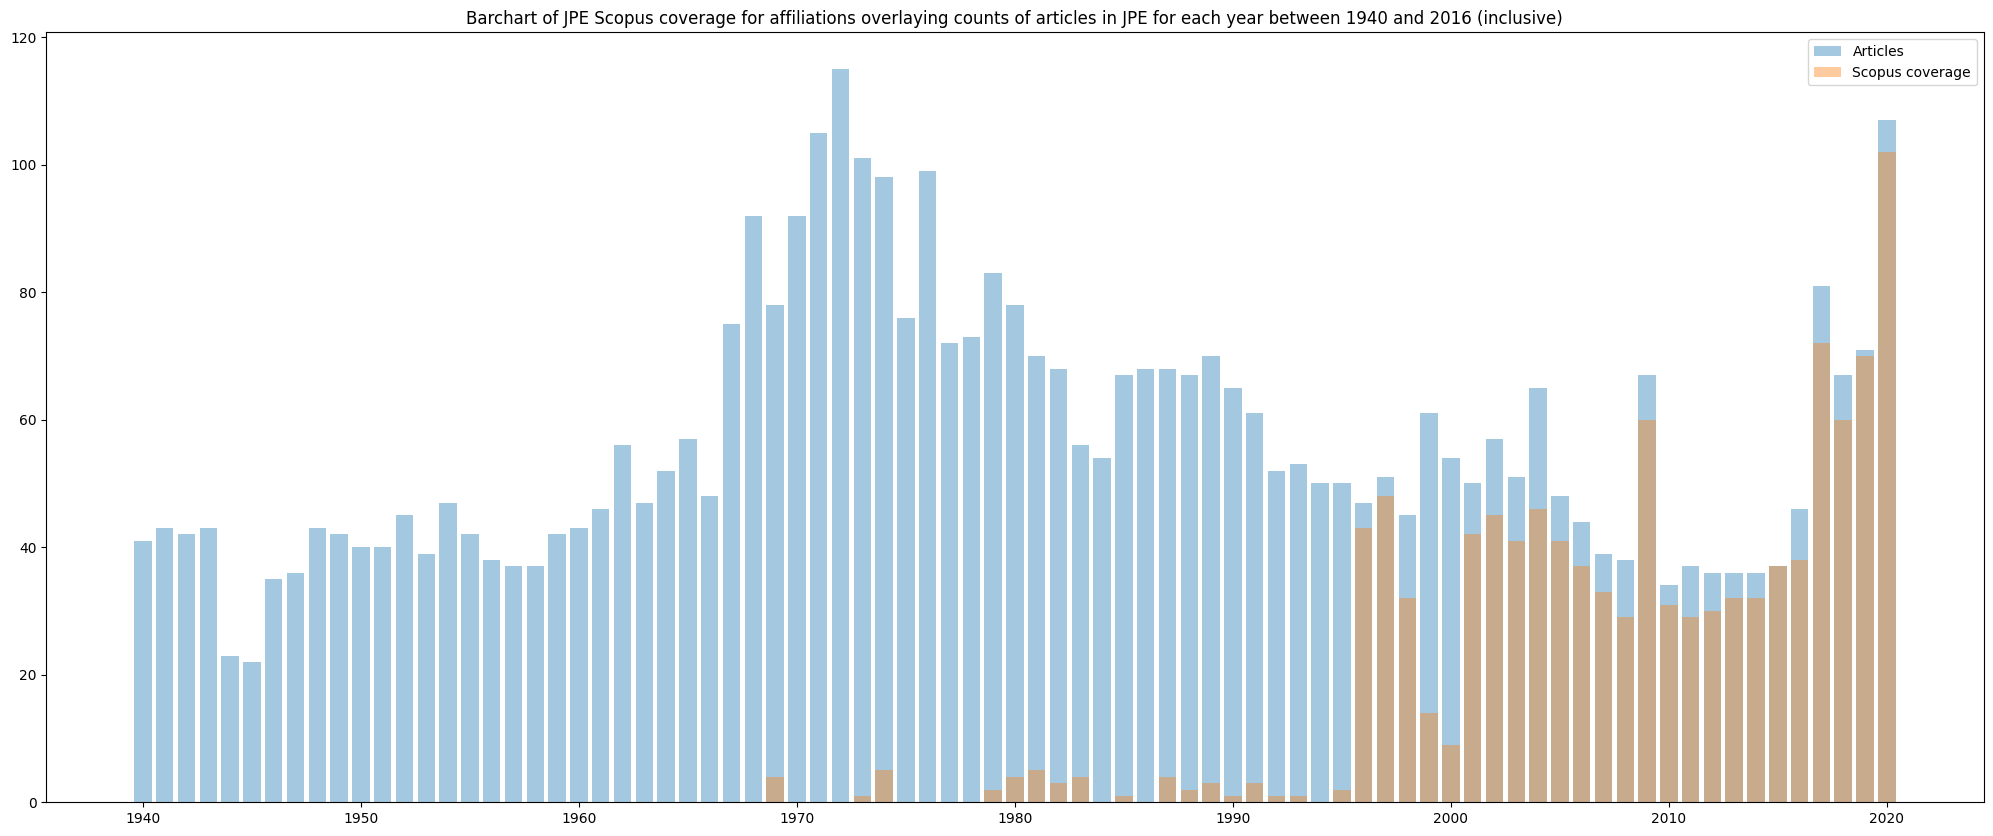

In [284]:
plt.rcParams["figure.figsize"] = (25, 10)
dta=Merged[(Merged['content_type']=='Article') & (Merged['year']>=1940)]['year'].value_counts()
plt.bar(dta.index,dta, label='Articles', alpha=0.4)
dta2=Merged[Merged['affiliations'].isnull()==False]['year'].value_counts()
plt.bar(dta2.index, dta2, label='Scopus coverage', alpha=0.4)
plt.title('Barchart of JPE Scopus coverage for affiliations overlaying counts of articles in JPE for each year between 1940 and 2016 (inclusive)')
plt.legend()

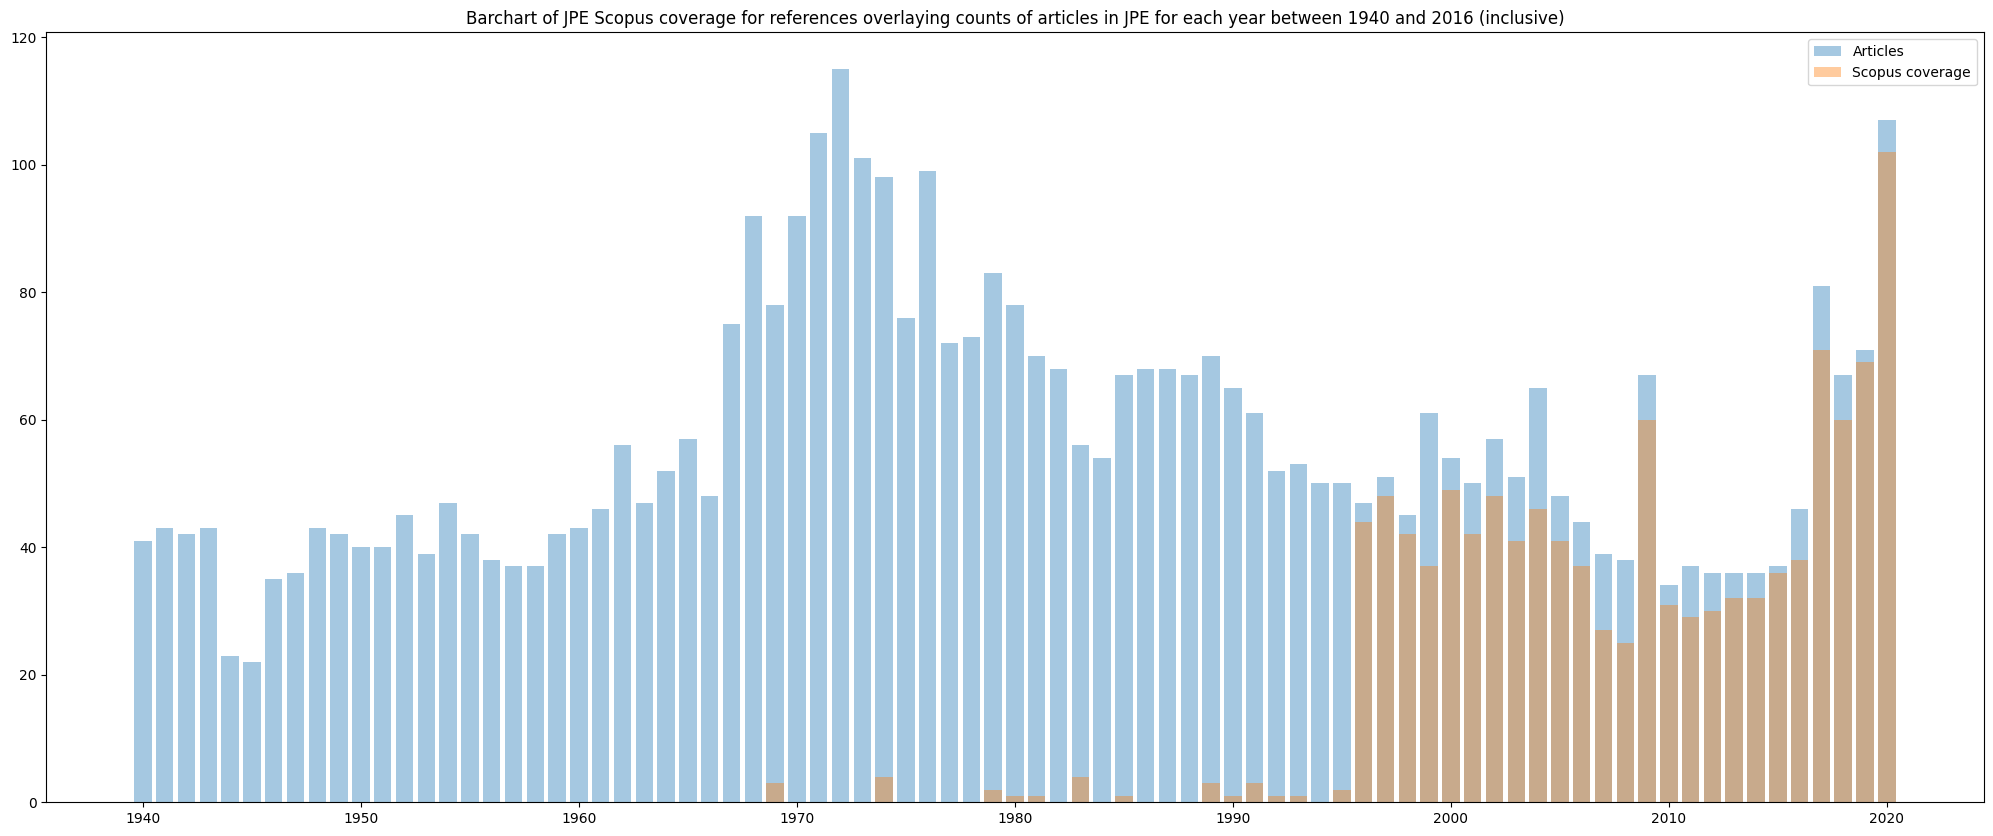

In [285]:
plt.rcParams["figure.figsize"] = (25, 10)
dta=Merged[(Merged['content_type']=='Article') & (Merged['year']>=1940)]['year'].value_counts()
dta.index
plt.bar(dta.index, dta, alpha=0.4, label='Articles')
dta3=Merged[Merged['citations'].isnull()==False]['year'].value_counts()
plt.bar(dta3.index, dta3, alpha=0.4, label='Scopus coverage')
dta4=Merged[Merged['citations'].isnull()==False]['year'].value_counts()
plt.title('Barchart of JPE Scopus coverage for references overlaying counts of articles in JPE for each year between 1940 and 2016 (inclusive)')
plt.legend()